## Introduction

This example shows how the [Captcha OCR](https://keras.io/examples/vision/captcha_ocr/)
example can be extended to the
[IAM Dataset](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database),
which has variable length ground-truth targets. Each sample in the dataset is an image of some
handwritten text, and its corresponding target is the string present in the image.
The IAM Dataset is widely used across many OCR benchmarks, so we hope this example can serve as a
good starting point for building OCR systems.

## Data collection

In [ ]:
!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
!unzip -qq IAM_Words.zip

!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

Preview how the dataset is organized. Lines prepended by "#" are just metadata information.

In [1]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


## Imports

In [2]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

## Dataset splitting

In [3]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

We will split the dataset into three subsets with a 90:5:5 ratio (train:validation:test).

In [4]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


## Data input pipeline

We start building our data input pipeline by first preparing the image paths.

In [5]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

Then we prepare the ground-truth labels.

In [6]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

Now we clean the validation and the test labels as well.

In [7]:

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

### Building the character vocabulary


Our project involves preprocessing labels at the character
level. This means that if there are two labels, e.g. "cat" and "dog", then our character
vocabulary should be {a, c, d, g, o, t} (without any special tokens). We use the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup/)
layer for this purpose.

In [8]:

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

### Resizing images without distortion

Instead of square images, many OCR models work with rectangular images. This will become
clearer in a moment when we will visualize a few samples from the dataset. While
aspect-unaware resizing square images does not introduce a significant amount of
distortion this is not the case for rectangular images. But resizing images to a uniform
size is a requirement for mini-batching. So we need to perform our resizing such that
the following criteria are met:

* Aspect ratio is preserved.
* Content of the images is not affected.

In [9]:

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


If we just go with the plain resizing then the images would look like so:

![](https://i.imgur.com/eqq3s4N.png)

Notice how this resizing would have introduced unnecessary stretching.

### Putting the utilities together

In [10]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return (image, label)


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


## Prepare `tf.data.Dataset` objects

In [11]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

## Visualize a few samples

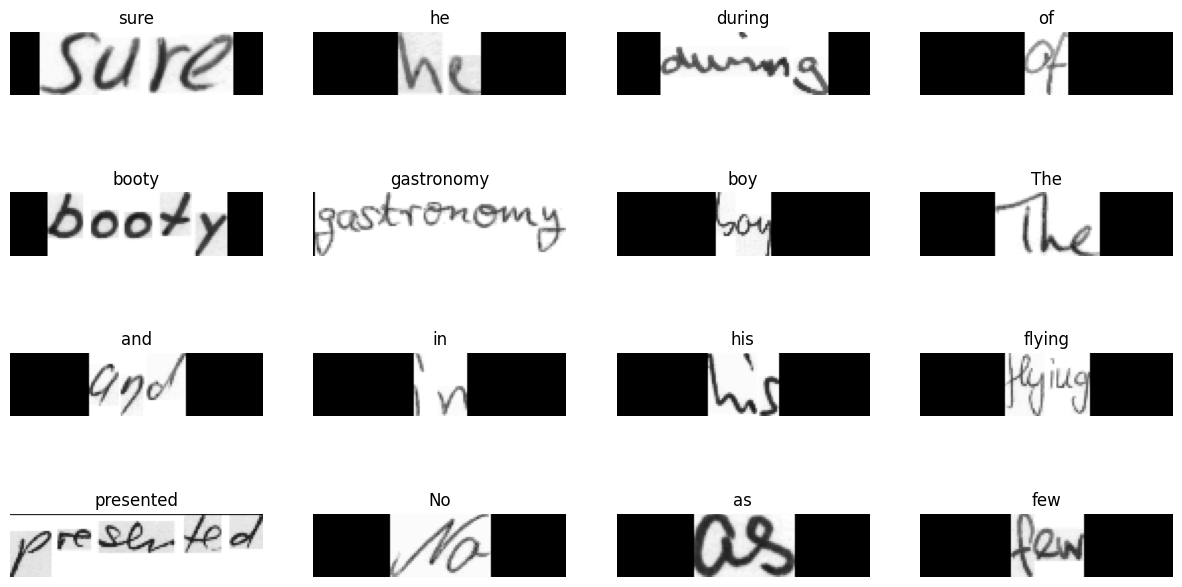

In [12]:
for data in train_ds.take(1):
    images, labels = data

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

You will notice that the content of original image is kept as faithful as possible and has
been padded accordingly.

## Model

Our model will use the CTC loss as an endpoint layer.

In [ ]:
new_shape = ((image_width // 4), (image_height // 4) * 64)

def ocr_model(shape=(image_width, image_height,  1)):
    model = tf.keras.models.Sequential([
        keras.Input(shape=shape),

        keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Reshape(target_shape=new_shape),

        keras.layers.Dense(64, activation="relu"),



        keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True)),

        keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True)),

        keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax")

    ])
    return model

# Get the model.
model = ocr_model()

In [13]:
def ctc_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

    return loss

## Compilation and Training

Now we are ready to kick off model training.

In [14]:
model = tf.keras.models.load_model("saved_model.keras", compile=False)

In [15]:
# Optimizer.
opt = keras.optimizers.Adam(lr =1e-4)

# Compile the model
model.compile(optimizer=opt, loss=ctc_loss)


In [ ]:
epochs = 1 # As we will be load model.

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,

)

## Inference

In [23]:
# model.save("up_work_.keras")

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 32, 32)       320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 16, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 32, 8, 64)         0         
 g2D)                                                            
                                                                 
 reshape_2 (Reshape)         (None, 32, 512)           0         
                                                                 
 dense_4 (Dense)             (None, 32, 64)           

2/2 [==============================] - 2s 95ms/step


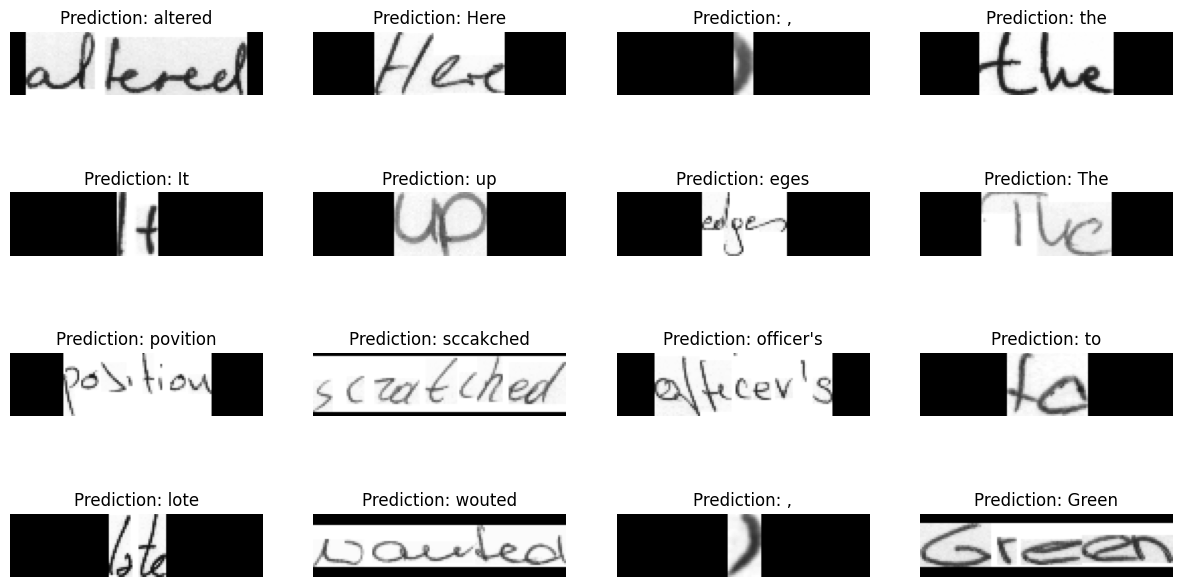

In [16]:

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch[0]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))
    preds = model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [17]:
import cv2
from google.colab.patches import cv2_imshow

In [19]:
def preprocess_user_sentence(image1, show_images = False):
    def remove_padded_255(arr):
        """
        Removes all padded 255 numbers in a 2d array and reshapes to its new shape.
        """
        # Find non-zero rows
        if len(arr.shape) >=3:
            arr = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
        arr = arr.copy() # Make copy so that it should affect actual image

        non_zero_rows = np.any(arr < 247, axis=1)


        # Filter the array based on non-zero rows
        filtered_arr = arr[non_zero_rows]

        # Reshape the filtered array
        return filtered_arr.reshape(-1, *filtered_arr.shape[1:])

    filtered_arr = remove_padded_255(image1)


    def find_w_streaks(array):
        """ This function finds streaks of "w" columns (all 255 values) in a 2D array. """
        streaks = [(0,3)]
        start_index = None
        for col in range(array.shape[1]):
            if np.all(array[:, col] > 240):
                if start_index is None:
                    start_index = col
            else:
                if start_index is not None :

                    if start_index!= 0  and ((col - 1 -start_index) > 3 ):
                        streaks.append((start_index, col - 1))

                    start_index = None

        streaks.append((array.shape[1] -3, array.shape[1]))
        return streaks

    w_streaks = find_w_streaks(filtered_arr)


    images = []
    for t1, t2 in zip(w_streaks, w_streaks[1:]):
        image = filtered_arr[:, t1[1]-3:t2[0]+3]
        image = np.expand_dims(image, axis=-1)
        image = distortion_free_resize(image, (image_width, image_height))
        image = image.numpy()

        image = (image/255.0).clip(0, 1).astype(np.float16)
        images.append(image)
    images = np.array(images)

    if show_images:
        images_show = (images*255.0).clip(0, 255).astype(np.float16)
        b, h, w, c = images.shape
        images_show = np.hstack(images_show)
        # cv2_imshow(images_show[0])
        cv2_imshow(images_show)
    return images



In [20]:
def predict(model, images):


  pred = model.predict(images)
  pred_texts = decode_batch_predictions(pred)
  return " ".join(pred_texts)


In [21]:
image1 =  cv2.imread("sentence.png")

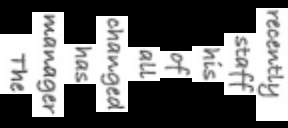

1/1 [==============================] - 2s 2s/step


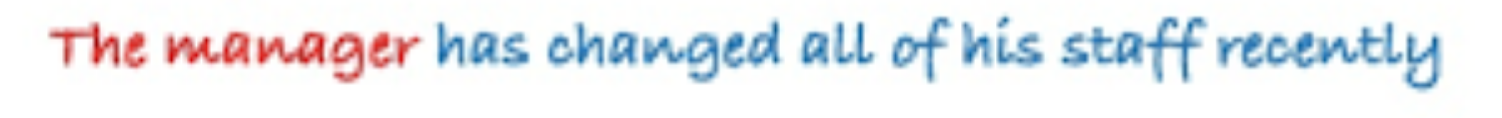

The manager has changed ple of hie staff remtly-


In [22]:
images = preprocess_user_sentence(image1, show_images=True)
output_text = predict(model, images)


cv2_imshow(image1)
print(output_text)